In [2]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sns.set_style("white")

In [5]:
FOLDER = '../input'
csv_path = os.path.join(FOLDER, 'training.csv')
sound_path = os.path.join(FOLDER, 'training')

In [188]:
df.columns

Index(['device_id', 'filename', 'tightening_result_torque', 'junction_type',
       'is_flange', 'sound_lengths', 'sound_mean', 'sound_min', 'sound_max',
       'sound_std'],
      dtype='object')

In [6]:
df = pd.read_csv(csv_path)
df.head()

,device_id,filename,tightening_result_torque,junction_type,is_flange
0,2,00001.wav,65.4,j_c,0
1,2,00002.wav,82.4,j_b,0
2,3,00003.wav,75.0,j_b,1
3,2,00004.wav,105.0,j_a,0
4,3,00005.wav,99.8,j_d,0


In [185]:
pd.get_dummies(df['device_id'], prefix='device_id')

,device_id_2,device_id_3
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
1225,0,1
1226,1,0
1227,1,0
1228,0,1


<AxesSubplot:>

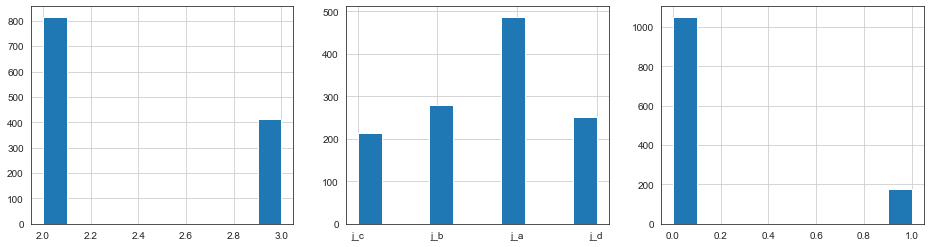

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
df.device_id.hist(ax=axes[0])
df.junction_type.hist(ax=axes[1])
df.is_flange.hist(ax=axes[2])

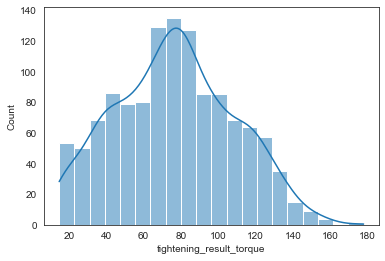

In [30]:
sns.histplot(df.tightening_result_torque, bins=20, kde=True);

In [26]:
df.tightening_result_torque.describe()

count    1230.000000
mean       76.591057
std        31.848536
min        14.800000
25%        53.400000
50%        76.800000
75%        98.200000
max       177.800000
Name: tightening_result_torque, dtype: float64

# Sound

In [67]:
import librosa
from tqdm.notebook import tqdm

In [235]:
SAMPLING_RATE = 192000

In [236]:
def read_file(path):
    """Read wav file"""
    wav, _ = librosa.core.load(path, sr=SAMPLING_RATE)
#     wav, _ = librosa.effects.trim(wav)
    return wav


def read_wav_files(path):
    """Read all wav files from directory"""
    features = []
    for filename in tqdm(os.listdir(path)):
        if filename.endswith(".wav"):
            wav = read_file(os.path.join(path, filename))
            features.append(wav)
    return features


def get_mel(wav):
    """Calculate melspectrogram"""
    melspec = librosa.feature.melspectrogram(
        wav,
        sr=SAMPLING_RATE,
        n_fft=1764,
        hop_length=220,
        n_mels=64
    )
    logmel = librosa.core.power_to_db(melspec)
    return logmel

In [86]:
data = read_wav_files(sound_path)

In [222]:
mel_specs = [get_mel(wav) for wav in data]

<AxesSubplot:ylabel='Count'>

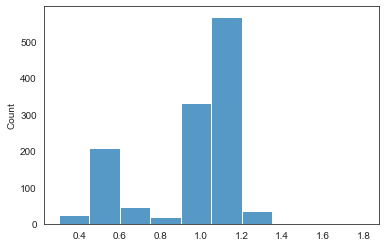

In [129]:
sound_lengths = np.array([len(wav)/SAMPLING_RATE for wav in data])
sns.histplot(sound_lengths, bins=10)

In [89]:
pd.Series(sound_lengths).value_counts()

1.1    567
1.0    291
0.5    207
0.9     39
0.6     37
1.2     34
0.4     21
0.8     19
0.7      8
0.3      3
1.4      2
1.8      1
1.3      1
dtype: int64

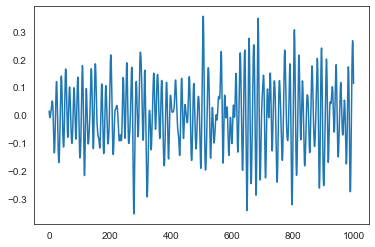

In [92]:
plt.plot(data[0][:1000])

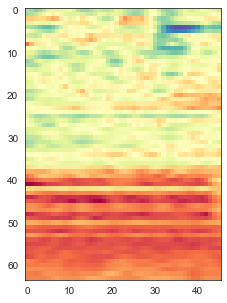

In [237]:
mel = get_mel(data[1][:10000])
fig, ax = plt.subplots(figsize=(16, 5))
ax.imshow(mel, cmap='Spectral', interpolation='nearest');

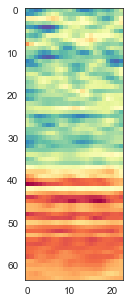

In [238]:
mel2 = get_mel(data[1][:5000])
fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(mel2, cmap='Spectral', interpolation='nearest');

In [221]:
np.sum(np.abs(mel[:, :mel2.shape[1]] - mel2), axis=0)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5258789e-05, 1.5258789e-05, 0.0000000e+00, 1.4324951e-01,
       1.0955318e+01, 4.9627419e+01, 1.2016543e+02], dtype=float32)

In [134]:
df['sound_lengths'] = sound_lengths

df['sound_mean'] = [wav.mean() for wav in data]
df['sound_min'] = [wav.min() for wav in data]
df['sound_max'] = [wav.max() for wav in data]
df['sound_std'] = [wav.std() for wav in data]

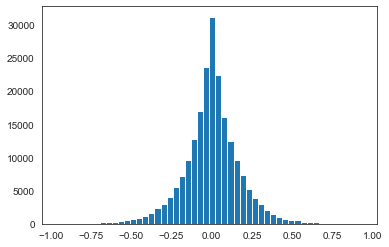

In [193]:
plt.hist(np.r_[wav], bins=50);

In [194]:
np.r_[wav].max(), np.r_[wav].min()

(0.9309387, -0.9603882)

In [230]:
mel_flat = np.concatenate(mel_specs, axis=1).flatten()
mel_flat.shape

(64417152,)

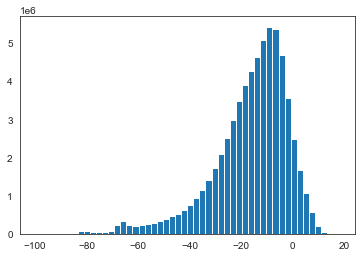

In [231]:
plt.hist(mel_flat, bins=50);

In [232]:
mel_flat.max(), mel_flat.min()

(18.07428, -100.0)

In [234]:
pd.Series([mel.shape[1] for mel in mel_specs]).value_counts()

961     567
873     291
437     207
786      39
524      37
1048     34
350      21
699      19
611       8
262       3
1222      2
1571      1
1135      1
dtype: int64

(array([ 24., 207.,  45.,  19., 330., 567.,  35.,   2.,   0.,   1.]),
 array([0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 , 1.65, 1.8 ]),
 <BarContainer object of 10 artists>)

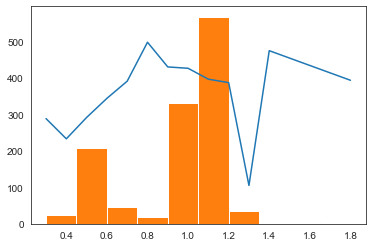

In [148]:
plt.plot(df.groupby('sound_lengths')['tightening_result_torque'].mean() * 5)
plt.hist(df['sound_lengths'])
# plt.plot(df.groupby('sound_lengths')['tightening_result_torque'].count() / 10)

<AxesSubplot:ylabel='Count'>

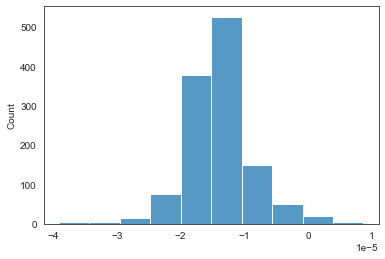

In [133]:
sound_mean = np.array([wav.mean() for wav in data])
sns.histplot(sound_mean, bins=10)

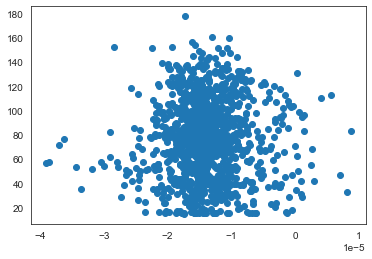

In [154]:
plt.scatter(df['sound_mean'], df['tightening_result_torque'])

In [187]:
low_std_idx = [df['filename'].iloc[i] for i in range(len(data)) if data[i].std() < 0.05]
low_std_idx

['00002.wav',
 '00044.wav',
 '00079.wav',
 '00172.wav',
 '00306.wav',
 '00396.wav',
 '00540.wav',
 '00629.wav',
 '00650.wav',
 '00723.wav',
 '01164.wav']

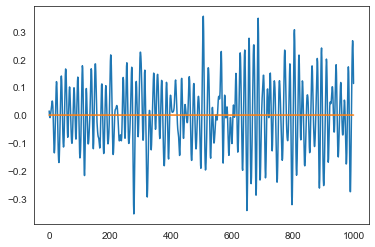

In [166]:
plt.plot(data[0][:1000])
plt.plot(data[low_std_idx[2]][:1000])

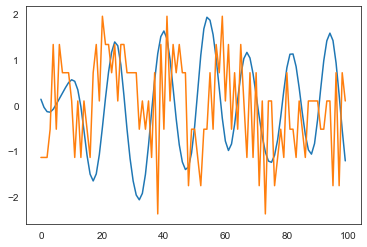

In [180]:
from sklearn.preprocessing import StandardScaler

plt.plot(StandardScaler().fit_transform(data[0][:100].reshape(-1, 1)).flatten())
plt.plot(StandardScaler().fit_transform(data[low_std_idx[2]][:100].reshape(-1, 1)).flatten())